# Analysis of Animal Shelter Data in Sonoma County, CA

## Goal of Analysis

Our main goal is to shed insight on the outcomes of animals surrendered to Sonoma County Animal Services.

## About the Data

## Data Assumptions?

## Methods

### EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
shelter_data = pd.read_csv('./Animal_Shelter_Data.csv')
shelter_data.shape

(25008, 24)

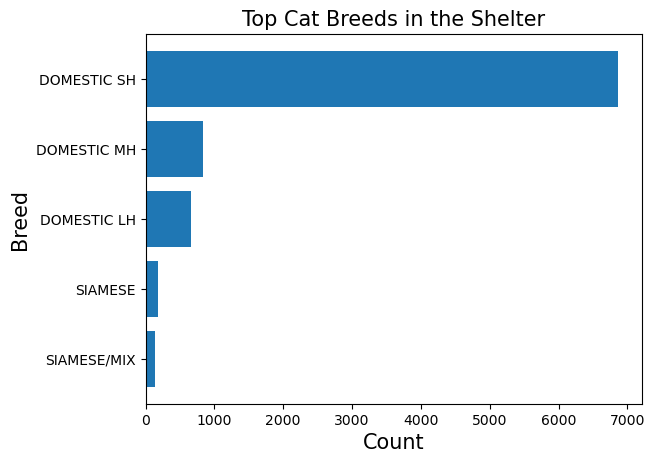

In [4]:
cat_data = shelter_data[shelter_data['Type'] == 'CAT']
cat_breed_counts = cat_data['Breed'].value_counts(ascending=True).tail(5)
plt.barh(cat_breed_counts.index, cat_breed_counts)
plt.title('Top Cat Breeds in the Shelter', size=15)
plt.xlabel('Count', size=15)
plt.ylabel('Breed', size=15)
plt.show()

### Modeling

## Results

## Conclusions

## Author Contributions